## AIT 590 - SECTION 002 - TEAM 007 - FINAL PROJECT
### DHRUVEETH PABBA | NAGA CHARITHA SADINENI | VENKATA SRI ATHULYA GOPISHETTY
### SENTIMENT ANALYSIS ON AMAZON FINE FOOD REVIEWS

### IMPORTING LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns
from tqdm import tqdm
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix
from wordcloud import WordCloud
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

### READING DATASET

In [2]:
#Reading the dataset into "data" using pandas
data=pd.read_csv("Reviews.csv")
#Printing the dataset
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [3]:
#Removing the data where score is 3
df = data[data.Score != 3]
#Shape of the data
print("The shape of the data:", df.shape)

### DATA PREPROCESSING

###### DIVIDING THE SCORES AS POSITIVE AND NEGATIVE

In [5]:
#Dividing the score into 'Positive' and 'Negative'
def partition(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

df1 = df['Score']
df2 = df1.map(partition)
df['Score'] = df2

###### PRINTING THE TOTAL POSITIVE AND NEGATIVE SCORES

In [6]:
#Printing the total positive and negative scores
print(df['Score'].value_counts()) 
print('='*55)
#Printing the updated dataset
df.head()

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


###### DE-DUPLICATION OF DATA

In [8]:
#Sorting data based on its product id
sort = df.sort_values('ProductId', ascending=True, axis=0)
#Printing the sorted data
sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [9]:
#Removing the duplicate values
data = sort.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
#The shape of the data after removing duplicate values
data.shape

(364133, 10)

In [10]:
#Percentage of the remaining original data
percent_data = (data.shape[0] / df.shape[0]) * 100
print(percent_data)

69.25129418387492


In [11]:
#Removing the records where helpfulness numerator is greater than helpfulness denominator
data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
#Shape of the data after removing records
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

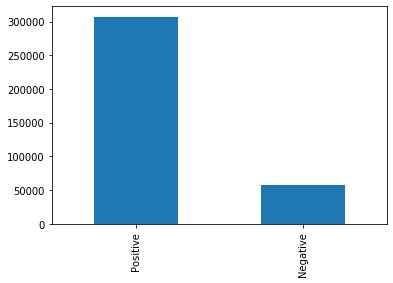

In [12]:
#Total number of positive and negative scores in the remaining orginal data
data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### DATA CLEANING

###### IDENTIFYING THE HTML TAGS

In [13]:
#Setting the count of html tags as 0
i = 0
for sentence in data['Text'].values:
    #Initializing Regular Expression to identify the html tags
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*55)
        #Printing the sentence in which we are counting the html tags
        print(sentence)
        break
    #Incrementing the count of the html tags
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


###### INITIALIZING THE FUNCTION TO REPLACE HTML TAGS

In [14]:
#Intializing function to remove HTML tags
def cleanHtml(sentence):
    #Regular Expression to identify the html tags
    html = re.compile('<.*?>')
    #Replacing the html tags with whitespaces
    cleanText = re.sub(html, ' ', sentence)    
    return cleanText

###### INITIALIZING FUNCTION TO REPLACE PUNCTUATION MARKS

In [15]:
#Initializing function to remove Punctuation marks
def cleanPunctuation(sentence):
    #Regular Expression to replace '?','$','.','!' with blank
    punct = re.sub(r'[?|$|.|!]',r'', sentence)
    #Regular Expression to replace '[','.','|',',','\','/' with whitespaces
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', punct)
    return cleanp

In [16]:
# Printing the set of stopwords
stopWords = set(stopwords.words('english'))
print(stopWords)

{'its', 'for', 'further', 'yours', 'this', 'it', 'all', "she's", 'because', 'my', 'you', "it's", 'who', 'on', 'mightn', "won't", 'shouldn', 'each', 'do', 'but', 'against', 'during', 'how', 'that', "isn't", 'didn', "hadn't", 'myself', 'those', 'shan', "wasn't", 'i', 'about', 'where', 'more', 'hasn', 'up', 'into', 'if', 'don', 'themselves', 'then', 'doesn', "you're", 'only', 'below', 'under', 'such', 'has', 'weren', 'won', 'very', 'himself', 'here', 'most', 'other', 'whom', 'are', "don't", 'wasn', 'not', 'her', 're', "you'd", 'ma', 'hadn', 'did', "couldn't", 'am', 'having', 'above', 'mustn', 'was', 'own', 'their', 'ours', 'both', 'off', 'theirs', "that'll", 'him', 'an', "you've", 'so', 'these', 'no', 'nor', 'they', 'can', 'been', 'hers', 'me', 'the', 'which', "should've", 'with', 'm', 'your', 'why', 'he', 'between', 'to', 'our', 'yourself', 'herself', 'out', 'or', 'will', 'while', 'too', 've', 'ourselves', 'aren', 'a', 'some', 'we', 'than', 'once', "wouldn't", "doesn't", 'by', 'now', 'do

###### INITIALIZING SNOWBALL STEMMER FOR STOP WORDS

In [17]:
# Initializing Snowball Stemmer
snowball = SnowballStemmer('english')

##### REMOVING HTML TAGS, PUNCTUATIONS, STOP WORDS

In [18]:
#Initializing the sentence count as 0
i = 0
initial_str = ''
#Final string of clean words
final_str = []  
#Positive Reviews
positive_words = [] 
#Negative Reviews
negative_words = []    
s = ''

for sentence in tqdm(data['Text'].values):
    #Initializing list to store filtered sentences
    filtered_sentence = []
    #Calling the function to remove the HTML tags
    sentence = cleanHtml(sentence) 
    #Splitting the sentences
    for words in sentence.split():
        #Calling the function to remove punctuation marks
        for word in cleanPunctuation(words).split():
            #Removing the numeric values
            if ((word.isalpha()) & (len(word) > 2)):
                #Removing the stopwords
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    #Appending the sentence to list of filtered_sentences
                    filtered_sentence.append(s)
                    #Appending the positive scored words into positive_words list
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    #Appending the negative scored words into negative_words list
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    #Final string of cleaned words
    initial_str = b" ".join(filtered_sentence)      
    final_str.append(initial_str)
    i += 1

100%|██████████| 364131/364131 [09:43<00:00, 624.23it/s] 


In [19]:
#Adding cleaned data to the dataset
data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")
#Printing the updated cleaned data
data.head()

In [21]:
#Sorting data based on time and putting the NaN values at the end
time = data.sort_values('Time', ascending=True, axis=0, na_position='last')       
time.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


###  SPLITTING DATA INTO TRAINING AND TESTING

In [22]:
#Splitting data into Train, Test and Cross-validation
X = time['CleanedText']
Y = time['Score']
#Initializing train_test_split function to split the dataset into training and testing
x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [23]:
print("Shape of training data:", x_train.shape, y_train.shape)
print("Shape of Cross Validation data:", x_cv.shape, y_cv.shape)
print("Shape of test data:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the Cross Validation data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


##### TRAINING DATA OF DECISION TREE

In [61]:
#Function for training data of Decision tree
def decision_train(x_train, x_cv, y_train, y_cv):
    #Passing samples
    samples = [5, 10, 50, 100, 500]
    #Passing the values for the depth of the tree
    depth = [5, 10, 50, 100]
    #list to store the accuracies 
    accuracies = []

    for i in samples:
        for j in depth:
            #Applying Decision tree classifier on data
            decision = DecisionTreeClassifier(min_samples_split=i, max_depth=j)
            decision.fit(x_train, y_train)

            #Function for prediction on cross validation data
            predict = decision.predict(x_cv)

            #Accuracy of cross validation data
            accuracy_of_cv = accuracy_score(y_cv, predict)
            #F1 score of cross validation data
            f1_score_cv = f1_score(y_cv, predict, average='macro')
            #Precision of cross validation data
            precision_of_cv = precision_score(y_cv, predict, average='macro')
            #Recall of cross validation data
            recall_of_cv = recall_score(y_cv, predict, average='macro')
            #Printing accuracy, f1 score, precision, and recall
            print("FOR samples =", i, "and depth =", j)
            print("Accuracy:", accuracy_of_cv*100)
            print("F1 score:", f1_score_cv*100)
            print("Precision:", precision_of_cv*100)
            print("Recall:", recall_of_cv*100)
            print("=="*55)
            #Appending accuracy of each sample to accuracies list
            accuracies.append(accuracy_of_cv)
    
    # Plot Heatmap for accuracy score
    cmap=sns.color_palette()
    print("---------- Representation of CV Accuracy Score in Heatmap ----------")
    accuracy_cv = np.array(accuracies)
    accuracy_cv = accuracy_cv.reshape(len(depth), len(samples))
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracy_cv, annot=True, cmap=cmap, fmt=".4f", xticklabels=samples, yticklabels=depth)
    plt.xlabel('Samples')
    plt.ylabel('Depth')
    plt.show()

##### TESTING DATA OF DECISION TREE

In [57]:
# Function for testing data of Decision tree
def decision_test(x_train, y_train, x_test, y_test, optimal_samples, optimal_depth):
    #Applying decision tree classifier
    dt = DecisionTreeClassifier(min_samples_split=optimal_samples, max_depth=optimal_depth)
    dt.fit(x_train, y_train)
    
    #Predicting the test data
    predict = dt.predict(x_test)
    
    #Printing the accuracy of model
    print("Accuracy:", accuracy_score(y_test, predict)*100)
    #Printing the macro f1 score of the model
    print("Macro f1 score:", f1_score(y_test, predict, average = 'macro')*100)
    #Printing the micro f1 score of the model
    print("Micro f1 score:", f1_score(y_test, predict, average = 'micro')*100)
    #Printing the precision of the model
    print("Precision:", precision_score(y_test, predict, average='macro')*100)
    #Printing the recall of the model
    print("Recall:", recall_score(y_test, predict, average='macro')*100)
    #Printing the classification report
    print("Classification Report:\n", classification_report(y_test, prediction))
    
    #Plotting the confusion matrix
    plot_confusion_matrix(y_test, prediction)
    plt.show()

##### TRAINING DATA OF RANDOM FOREST

In [26]:
# Function for training data of Random Forest
def rf_train(x_train, x_cv, y_train, y_cv):
    #Passing the estimators
    estimators = [x for x in range(100, 601, 100)]
    #Passing the values for the depth of the tree 
    depth = [x for x in range(2, 15, 2)]
    #Empty list to store the accuracies
    accuracies = []

    for i in estimators:
        for j in depth:
            #Initializing the Random Forest Classifier
            rf = RandomForestClassifier(n_estimators=i, max_depth=j, class_weight='balanced', n_jobs=-1)
            rf.fit(x_train, y_train)

            #Predicting the cross validation data
            prediction = rf.predict(x_cv)

            #Accuracy of cross validation data
            accuracy_of_cv = accuracy_score(y_cv, prediction)
            #F1 score of cross validation data
            f1_score_cv = f1_score(y_cv, prediction, average='macro')
            #Precision of cross validation data
            precision_of_cv = precision_score(y_cv, prediction, average='macro')
            #Recall of cross validation data
            recall_of_cv = recall_score(y_cv, prediction, average='macro')
            #Printing accuracy, f1 score, precision, and recall
            print("FOR estimators =", i, "and depth =", j)
            print("Accuracy:", accuracy_of_cv*100)
            print("F1_score:", f1_score_cv*100)
            print("Precision:", precision_of_cv*100)
            print("Recall:", recall_of_cv*100)
            print("=="*55)
            #Appending accuracy of each sample to accuracies list
            accuracies.append(accuracy_of_cv)

    # Plot Heatmap for accuracy score
    cmap=sns.color_palette()
    print("---------- Representation of CV Accuracy Score in Heatmap ----------")
    accuracy_cv = np.array(accuracies)
    accuracy_cv = accuracy_cv.reshape(len(depth), len(estimators))
    plt.figure(figsize=(10, 5))
    sns.heatmap(accuracy_cv, annot=True, cmap=cmap, fmt=".4f", xticklabels=estimators, yticklabels=depth)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Depth')
    plt.show()

##### TESTING DATA OF RANDOM FOREST

In [27]:
# Function for testing data of Random Forest
def rf_test(x_train, y_train, x_test, y_test, optimal_estimators, optimal_depth):
    #Initializing the Random Forest Classifier
    rf = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced', n_jobs=-1)
    rf.fit(x_train, y_train)
    
    #Predicting the test data
    prediction = rf.predict(x_test)

    #Printing the accuracy of model
    print("Accuracy:", accuracy_score(y_test, prediction)*100)
    #Printing the macro f1 score of the model
    print("Macro f1 score:", f1_score(y_test, prediction, average = 'macro')*100)
    #Printing the micro f1 score of the model
    print("Micro f1 score:", f1_score(y_test, prediction, average = 'micro')*100)
    #Printing the precision of the model
    print("Precision:", precision_score(y_test, prediction, average='macro')*100)
    #Printing the recall of the model
    print("Recall:", recall_score(y_test, prediction, average='macro')*100)
    #Printing the classification report
    print("Classification report:\n", classification_report(y_test, prediction))
    
    #Plotting the confusion matrix
    plot_confusion_matrix(y_test, prediction)
    plt.show()

##### TRAINING DATA OF SVM

In [28]:
#Initializing function for SVM train
def svm_train(x_train, x_cv, y_train, y_cv, algo):
    # Here alpha serves both for itself and c as well
    alpha = [10**x for x in range(-5, 4)]     
    #Empty list to store the accuracies
    accuracies = []

    for i in alpha[0:]:
        if (algo == 'Linear'):
            model=SGDClassifier(alpha=i)
            svm = CalibratedClassifierCV(base_estimator=model)
        elif (algo == 'RBF'):
            svm = SVC(C=i, probability=True)
        svm.fit(x_train, y_train)
        
        #Predicting the cross validation data
        prediction = svm.predict(x_cv)
        
        #Accuracy of cross validation data
        accuracy_of_cv = accuracy_score(y_cv, prediction)
        #F1 score of cross validation data
        f1_score_cv = f1_score(y_cv, prediction, average='macro')
        #Precision of cross validation data
        precision_of_cv = precision_score(y_cv, prediction, average='macro')
        #Recall of cross validation data
        recall_of_cv = recall_score(y_cv, prediction, average='macro')
        #Printing accuracy, f1 score, precision, and recall
        print("FOR α =", i)
        print("Accuracy:", accuracy_of_cv*100)
        print("F1_score:", f1_score_cv*100)
        print("Precision:", precision_of_cv*100)
        print("Recall:", recall_of_cv*100)
        print("=="*55)
        #Appending accuracy of each sample to accuracies list
        accuracies.append(accuracy_of_cv)
        
    # Plot α vs auc_score graph
    plt.plot(alpha, accuracies, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("α v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('alpha (α)')
    plt.show()

##### TESTING DATA OF SVM

In [29]:
#Initializing SVM function to test the model
def svm_test(x_train, y_train, x_test, y_test, optimal_alpha, algo):
    if (algo == 'Linear'):
        # Here optimum_alpha serves both for itself and optimal_c as well
        model=SGDClassifier(alpha=optimal_alpha)            
        svm = CalibratedClassifierCV(base_estimator=model)
    elif (algo == 'RBF'):
        # Here optimum_alpha serves both for itself and optimal_c as well
        svm = SVC(C=optimal_alpha, probability=True)        
    svm.fit(x_train, y_train)
    
    #Predicting the test data
    prediction = svm.predict(x_test)

    #Printing the accuracy of model
    print("Accuracy:", accuracy_score(y_test, prediction)*100)
    #Printing the macro f1 score of the model
    print("Macro f1 score:", f1_score(y_test, prediction, average = 'macro')*100)
    #Printing the micro f1 score of the model
    print("Micro f1 score:", f1_score(y_test, prediction, average = 'micro')*100)
    #Printing the precision of the model
    print("Precision:", precision_score(y_test, prediction, average='macro')*100)
    #Printing the recall of the model
    print("Recall:", recall_score(y_test, prediction, average='macro')*100)
    #Printing the classification report
    print("Classification Report:\n", classification_report(y_test, prediction))
    
    #Plotting the confusion matrix
    plot_confusion_matrix(y_test, prediction)
    plt.show()

##### TRAINING DATA OF LOGISTIC REGRESSION

In [30]:
#Initializing function for Logistic train
def logistic_train(x_train, x_cv, y_train, y_cv, penal):
    #Passing the c values
    C = [10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001]
    #Empty list to store the accuracies
    accuracies = []

    for i in C[0:]:
        #Applying Logistic Regression
        logistic = LogisticRegression(penalty=penal, C=i)
        logistic.fit(x_train, y_train)
        
        #Predicting the cross validation data
        prediction = logistic.predict(x_cv)
        
        #Accuracy of cross validation data
        accuracy_of_cv = accuracy_score(y_cv, prediction)
        #F1 score of cross validation data
        f1_score_cv = f1_score(y_cv, prediction, average='macro')
        #Precision of cross validation data
        precision_of_cv = precision_score(y_cv, prediction, average='macro')
        #Recall of cross validation data
        recall_of_cv = recall_score(y_cv, prediction, average='macro')
        
        #Printing accuracy, f1 score, precision, and recall
        print("FOR λ =", i)
        print("Accuracy:", accuracy_of_cv*100)
        print("F1_score:", f1_score_cv*100)
        print("Precision:", precision_of_cv*100)
        print("Recall:", recall_of_cv*100)
        print("=="*55)
        
        #Appending accuracy of each sample to accuracies list
        accuracies.append(accuracy_of_cv)
        
    # Plot λ vs auc_score graph
    plt.plot(C, accuracies, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("λ v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('λ')
    plt.show()

##### TESTING DATA OF LOGISTIC REGRESSION

In [31]:
#Initializing function to test the model
def logistic_test(x_train, y_train, x_test, y_test, penal, optimal_C):
    #Applying Logistic Regression
    logistic = LogisticRegression(penalty=penal, C=optimal_C)
    logistic.fit(x_train, y_train)
    
    #Predicting the test data
    prediction = logistic.predict(x_test)

    #Printing the accuracy of model
    print("Accuracy:", accuracy_score(y_test, prediction)*100)
    #Printing the macro f1 score of the model
    print("Macro f1 score:", f1_score(y_test, prediction, average = 'macro')*100)
    #Printing the micro f1 score of the model
    print("Micro f1 score:", f1_score(y_test, prediction, average = 'micro')*100)
    #Printing the precision of the model
    print("Precision:", precision_score(y_test, prediction, average='macro')*100)
    #Printing the recall of the model
    print("Recall:", recall_score(y_test, prediction, average='macro')*100)
    #Printing the classification report
    print("Classification Report:\n", classification_report(y_test, prediction))
    
    #Plotting the confusion matrix
    plot_confusion_matrix(y_test, prediction)
    plt.show()

##### TRAINING DATA OF K-NEAREST NEIGHBORS

In [32]:
#Initializing KNN to train the model
def knn_train(x_train, x_cv, y_train, y_cv, algo):
    #Empty list for k values 
    k = []
    #Empty list to store accuracies
    accuracies = []

    for i in range(2, 25, 2):
        # Applying KNN Classifier
        neighbor = KNeighborsClassifier(n_neighbors=i, algorithm=algo)
        neighbor.fit(x_train, y_train)
        
        #Predicting the cross validation data
        prediction = neighbor.predict(x_cv)
        
        #Accuracy of cross validation data
        accuracy_of_cv = accuracy_score(y_cv, prediction)
        #F1 score of cross validation data
        f1_score_cv = f1_score(y_cv, prediction, average='macro')
        #Precision of cross validation data
        precision_of_cv = precision_score(y_cv, prediction, average='macro')
        #Recall of cross validation data
        recall_of_cv = recall_score(y_cv, prediction, average='macro')
        
        #Printing accuracy, f1 score, precision, and recall
        print("FOR K =", i)
        print("Accuracy:", accuracy_of_cv*100)
        print("F1 score:", f1_score_cv*100)
        print("Precision:", precision_of_cv*100)
        print("Recall:", recall_of_cv*100)
        print("=="*55)
        
        #Appending i values into k
        k.append(i)
        #Appending accuracy of each sample to accuracies list
        accuracies.append(accuracy_of_cv)
        
    # Plot k vs auc_score graph
    plt.plot(k, accuracies, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("K v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('K')
    plt.show()

##### TESTING OF K-NEAREST NEIGHBORS

In [33]:
#Initializing function to test the model
def knn_test(x_train, y_train, x_test, y_test, algo, optimal_k):
    #Applying KNN Classifier
    neighbor = KNeighborsClassifier(n_neighbors=optimal_k, algorithm=algo) 
    neighbor.fit(x_train, y_train)
    
    #Predicting the test data
    prediction = neighbor.predict(x_test)

    #Printing the accuracy of model
    print("Accuracy:", accuracy_score(y_test, prediction)*100)
    #Printing the macro f1 score of the model
    print("Macro F1 score:", f1_score(y_test, prediction, average = 'macro')*100)
    #Printing the micro f1 score of the model
    print("Micro F1 score:", f1_score(y_test, prediction, average = 'micro')*100)
    #Printing the precision of the model
    print("Precision:", precision_score(y_test, prediction, average='macro')*100)
    #Printing the recall of the model
    print("Recall:", recall_score(y_test, prediction, average='macro')*100)
    #Printing the classification report
    print("Classification Report:\n", classification_report(y_test, prediction))
    
    #Plotting the confusion matrix
    plot_confusion_matrix(y_test, prediction)
    plt.show()

### FEATURE SELECTION

##### TOP 20 FEATURES OF DECISION TREE

In [34]:
# Function for top 20 features of decision tree models
def top_features(x_train, y_train, vectorizer, optimal_samples, optimal_depth):
    n = 20
    #Empty list to store features
    features = []
    all_features = vectorizer.get_feature_names()
    #Applying Decision tree classifier
    model = DecisionTreeClassifier(min_samples_split=optimal_samples, max_depth=optimal_depth)
    model.fit(x_train, y_train)
    coefs = sorted(zip(model.feature_importances_, all_features))
    top = coefs[:-(n + 1):-1]
    
    #Printing the Feature Importance
    print('\033[1m' + "Feature Importance \t Features" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-2s" % (coef1, feat1))
        features.append(feat1)
    
    #Generating and plotting the Word Cloud
    wordcloud = WordCloud(background_color='black', width=1600, height=800).generate(" ".join(features))
    fig = plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

##### TOP 20 FEATURES OF RANDOM FOREST

In [35]:
# Function for top 20 features of Random Forest
def top_features_rand(x_train, y_train, vectorizer, optimal_estimators, optimal_depth):
    n = 20
    #Empty list to store features
    features = []
    all_features = vectorizer.get_feature_names()
    #Applying Random Forest Classifier
    model = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced', n_jobs=-1)
    model.fit(x_train, y_train)
    coefs = sorted(zip(model.feature_importances_, all_features))
    top = coefs[:-(n + 1):-1]
    
    #Printing the feature importance
    print('\033[1m' + "Feature Importance \t Features" + '\033[0m')
    print("="*35)
    
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-2s" % (coef1, feat1))
        features.append(feat1)
    
    #Generating and Plotting the Word Cloud
    wordcloud = WordCloud(background_color='black', width=1200, height=600).generate(" ".join(features))
    fig = plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

##### TOP 20 FEATURES OF SVM

In [36]:
#Function for top 20 features of SVM
def top_features_svm(x_train, y_train, vectorizer, optimal_alpha, algo):
    all_features = vectorizer.get_feature_names()
    if (algo == 'Linear'):
        model = SGDClassifier(alpha=optimal_alpha)            # Here optimum_alpha serves both for itself and optimal_c as well
    elif (algo == 'RBF'):
        model = SVC(C=optimal_alpha, probability=True)        # Here optimum_alpha serves both for itself and optimal_c as well
    model.fit(x_train, y_train)
    weight = model.coef_
    top_positive = np.argsort(weight)[:,::-1]
    top_negative = np.argsort(weight)
    
    #Printing top 10 positive features
    print('These are the Top 10 Positive Features:')
    for i in list(top_positive[0][0:10]):
        print("\t", all_features[i])
        
    #Printing top 10 negative features
    print('These are the Top 10 Negative Features:')
    for i in list(top_negative[0][0:10]):
        print("\t", all_features[i])

##### GRAPHICAL VISUALIZATION OF DECISION TREE

In [37]:
# Function for Graphical Visualization of decision tree models

def construct_tree(x_train, y_train, vectorizer, optimal_samples, optimal_depth):
    all_features = vectorizer.get_feature_names()
    model = tree.DecisionTreeClassifier(max_depth=optimal_depth, min_samples_split=optimal_samples, random_state=0)
    model.fit(x_train, y_train)
    plt.figure(figsize=(12,12))
    tree.plot_tree(model, feature_names=all_features, max_depth=2, fontsize=10)
    plt.title("Decision Tree on Amazon Fine Food Reviews (Gini)")

### VECTORIZATION OF SPLITTED DATA

###### BAG OF WORDS

In [38]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [39]:
print("Shape of the training data:", x_train_bow.shape, y_train.shape)
print("Shape of the CV data:", x_cv_bow.shape, y_cv.shape)
print("Shape of the test data:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1927351) (191168,)
The shape of the CV data is: (81930, 1927351) (81930,)
The shape of the test data is: (91033, 1927351) (91033,)


###### TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY (TF-IDF)

In [40]:
# Term Frequency - Inverse Document Frequency (TF-IDF)
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [41]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1927351) (191168,)
The shape of the CV data is: (81930, 1927351) (81930,)
The shape of the test data is: (91033, 1927351) (91033,)


### APPLYING RANDOM FOREST ON OUR MODEL

###### BAG OF WORDS

FOR estimators = 100 and depth = 2
The accuracy of the model is: 78.07762724276822
The f1_score of the model is: 64.16212553694211
The precision_score of the model is: 62.88600724308289
The recall_score of the model is: 66.87371093997324
FOR estimators = 100 and depth = 4
The accuracy of the model is: 80.1708775784206
The f1_score of the model is: 69.37398224878272
The precision_score of the model is: 67.30126618243774
The recall_score of the model is: 74.69771216802319
FOR estimators = 100 and depth = 6
The accuracy of the model is: 78.70499206639815
The f1_score of the model is: 68.97568071743072
The precision_score of the model is: 67.01951873221168
The recall_score of the model is: 76.32776815463187
FOR estimators = 100 and depth = 8
The accuracy of the model is: 82.17380690833639
The f1_score of the model is: 71.67444825018944
The precision_score of the model is: 69.38688884578468
The recall_score of the model is: 76.53249280093131
FOR estimators = 100 and depth = 10
The accuracy 

FOR estimators = 400 and depth = 8
The accuracy of the model is: 87.51373123398022
The f1_score of the model is: 79.27743729475014
The precision_score of the model is: 76.48941485690324
The recall_score of the model is: 83.85460953627003
FOR estimators = 400 and depth = 10
The accuracy of the model is: 87.57231783229587
The f1_score of the model is: 79.20956105158042
The precision_score of the model is: 76.53329103783258
The recall_score of the model is: 83.47080427784948
FOR estimators = 400 and depth = 12
The accuracy of the model is: 88.48285121445136
The f1_score of the model is: 80.38613133247172
The precision_score of the model is: 77.86457754180111
The recall_score of the model is: 84.1186981166591
FOR estimators = 400 and depth = 14
The accuracy of the model is: 88.40107408763579
The f1_score of the model is: 80.43795549148241
The precision_score of the model is: 77.75918779187148
The recall_score of the model is: 84.54946753846852
FOR estimators = 500 and depth = 2
The accurac

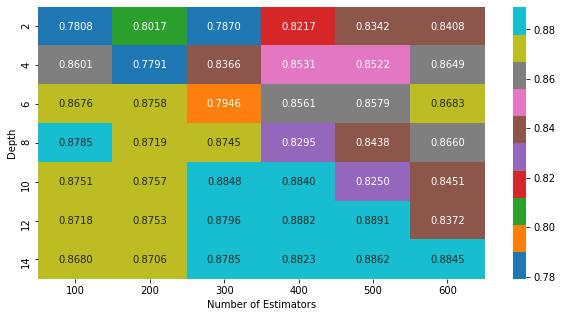

In [42]:
#Calling the Random Forest function train to run the model using Bag of words
#This may take several minutes to run
rf_train(x_train_bow, x_cv_bow, y_train, y_cv)

The accuracy of the model is: 88.06257071611394
The macro f1_score of the model is: 79.79574728019792
The micro f1_score of the model is: 88.06257071611394
The precision_score of the model is: 77.35090719279157
The recall_score of the model is: 83.41884583520816
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.59      0.77      0.67     14310
    Positive       0.95      0.90      0.93     76723

    accuracy                           0.88     91033
   macro avg       0.77      0.83      0.80     91033
weighted avg       0.90      0.88      0.89     91033



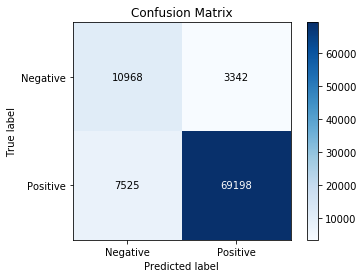

In [43]:
#Calling the Random Function to test our model
rf_test(x_train_bow, y_train, x_test_bow, y_test, optimal_estimators=600, optimal_depth=12)

Feature Importance 	 Features
0.0094			return
0.0090			wast
0.0086			best
0.0068			disappoint
0.0066			thought
0.0064			wast money
0.0059			aw
0.0059			love
0.0055			review
0.0054			great
0.0052			bad
0.0050			perfect
0.0045			read
0.0043			delici
0.0041			worst
0.0039			great tast
0.0039			easi
0.0039			hope
0.0038			amaz
0.0038			stick


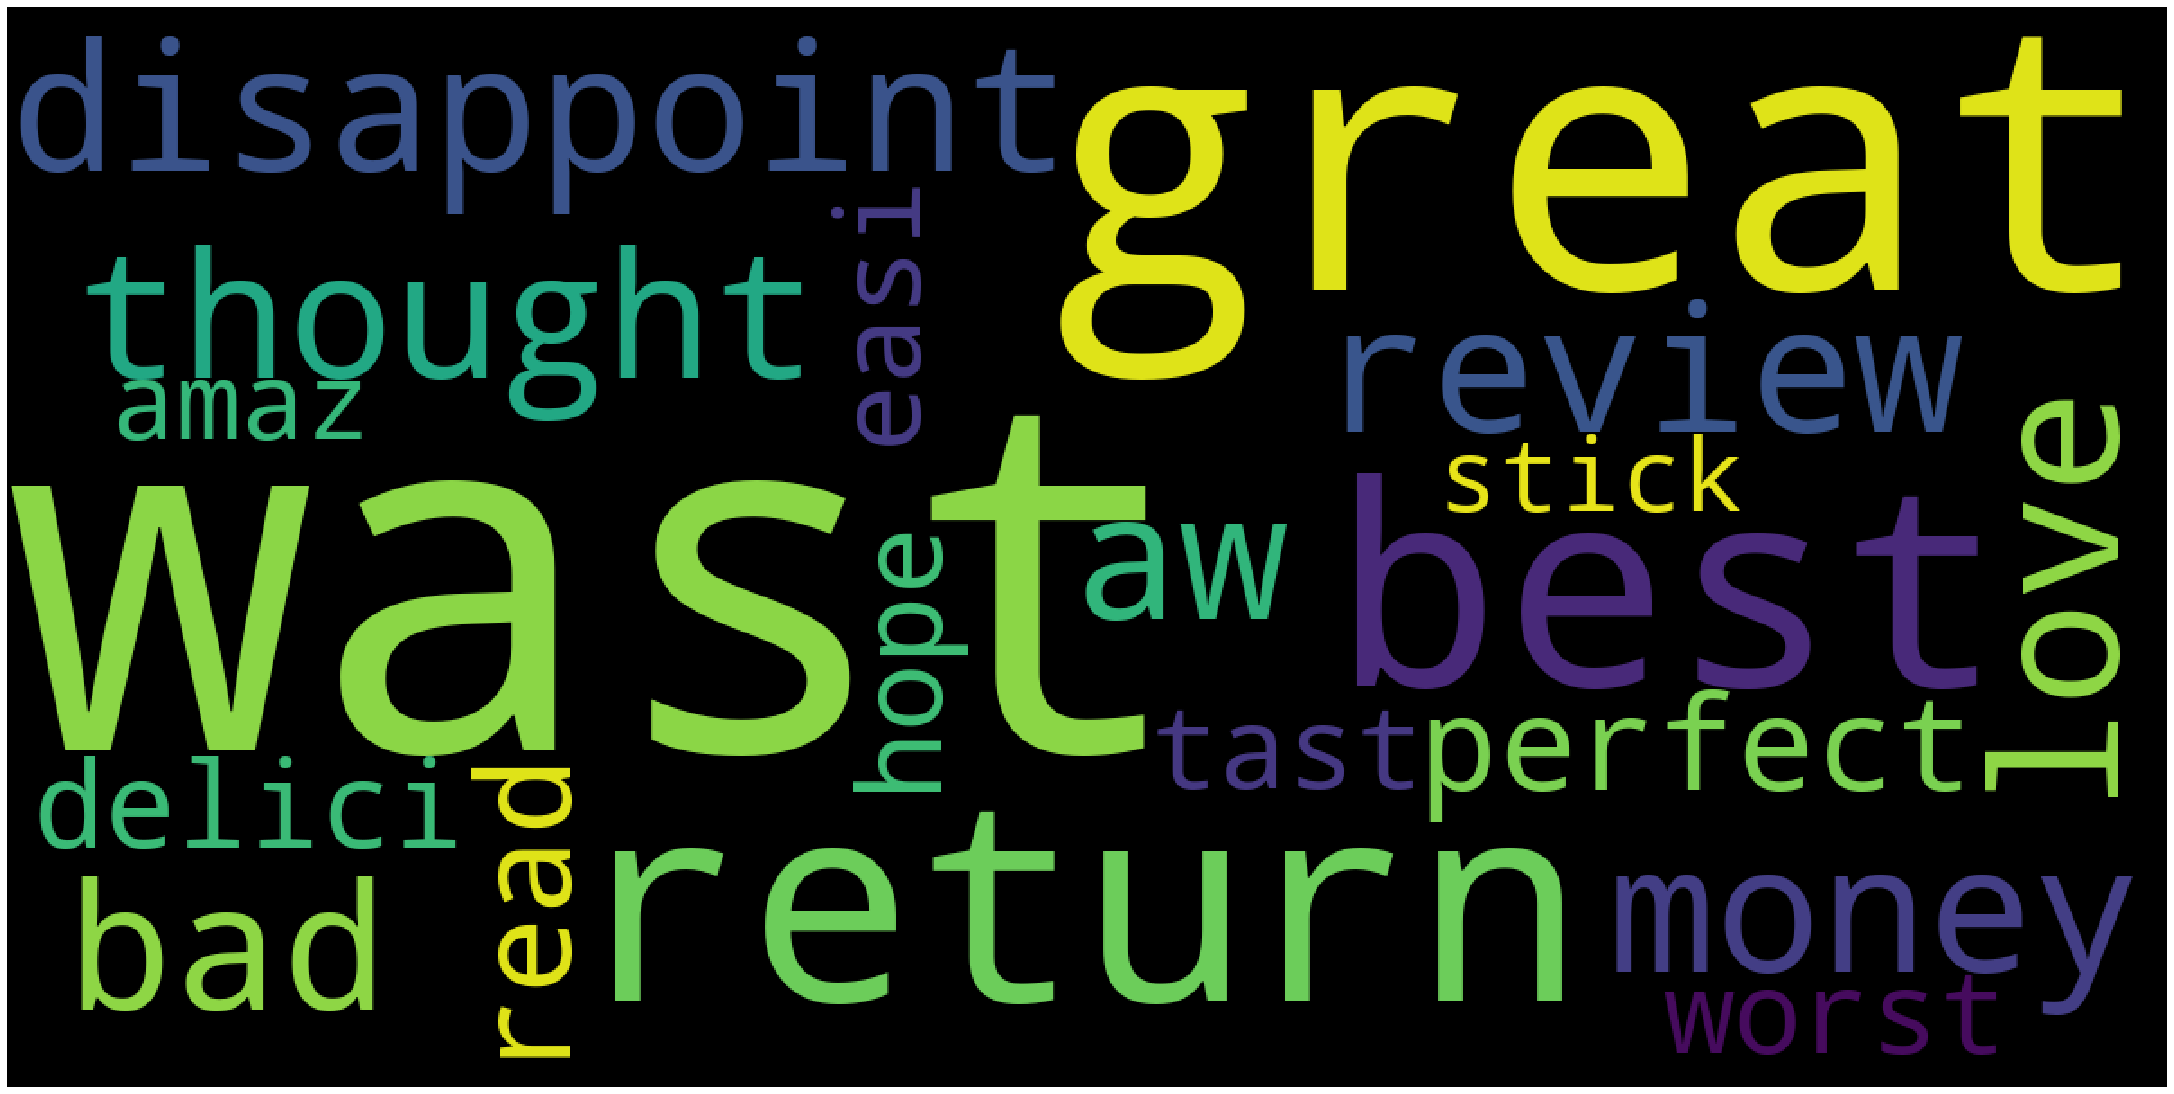

In [44]:
#Top features of Random Forest
top_features_rand(x_train_bow, y_train, count_vect, optimal_estimators=600, optimal_depth=12)

###### TF-IDF

FOR estimators = 100 and depth = 2
The accuracy of the model is: 61.0313682411815
The f1_score of the model is: 55.13349484895329
The precision_score of the model is: 59.78159494709351
The recall_score of the model is: 68.56944258042755
FOR estimators = 100 and depth = 4
The accuracy of the model is: 76.01855242279996
The f1_score of the model is: 65.22968258255166
The precision_score of the model is: 63.88239855788888
The recall_score of the model is: 71.60909373882396
FOR estimators = 100 and depth = 6
The accuracy of the model is: 81.47687049920664
The f1_score of the model is: 71.00980663717682
The precision_score of the model is: 68.7472415498202
The recall_score of the model is: 76.24751115206519
FOR estimators = 100 and depth = 8
The accuracy of the model is: 82.77309898694007
The f1_score of the model is: 72.90636474682447
The precision_score of the model is: 70.41333894460944
The recall_score of the model is: 78.37295991176023
FOR estimators = 100 and depth = 10
The accuracy o

FOR estimators = 400 and depth = 8
The accuracy of the model is: 87.17685829366533
The f1_score of the model is: 78.22822937518252
The precision_score of the model is: 75.85277504354362
The recall_score of the model is: 81.81814788605939
FOR estimators = 400 and depth = 10
The accuracy of the model is: 87.04870010984988
The f1_score of the model is: 78.35321019770542
The precision_score of the model is: 75.75011324758198
The recall_score of the model is: 82.53133211782485
FOR estimators = 400 and depth = 12
The accuracy of the model is: 87.0621262052972
The f1_score of the model is: 78.11126898677627
The precision_score of the model is: 75.69572866537104
The recall_score of the model is: 81.81409012941879
FOR estimators = 400 and depth = 14
The accuracy of the model is: 87.71390211155865
The f1_score of the model is: 79.16992221594717
The precision_score of the model is: 76.68790235261817
The recall_score of the model is: 82.9253061227694
FOR estimators = 500 and depth = 2
The accuracy

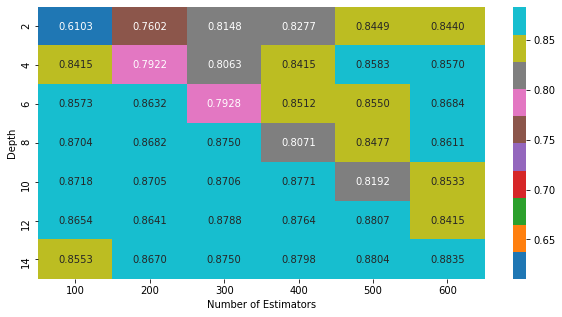

In [45]:
#Calling the Random Forest function to train our model using TF-IDF
#This may take several minutes
rf_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv)

The accuracy of the model is: 88.02082761196489
The macro f1_score of the model is: 79.3117640161757
The micro f1_score of the model is: 88.02082761196489
The precision_score of the model is: 77.24600671242344
The recall_score of the model is: 82.15481026597419
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.60      0.74      0.66     14310
    Positive       0.95      0.91      0.93     76723

    accuracy                           0.88     91033
   macro avg       0.77      0.82      0.79     91033
weighted avg       0.89      0.88      0.89     91033



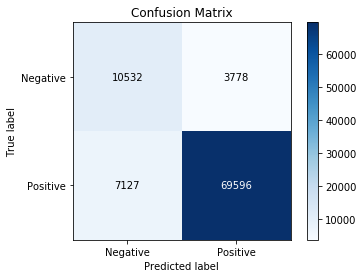

In [46]:
#Calling the Random Forest function to test the model
rf_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_estimators=600, optimal_depth=14)

Feature Importance 	 Features
0.0101			great
0.0100			love
0.0072			terribl
0.0069			bad
0.0059			wast
0.0057			would
0.0054			best
0.0054			aw
0.0054			tasti
0.0049			money
0.0048			make
0.0048			perfect
0.0046			poor
0.0043			disappoint
0.0043			product
0.0043			tast like
0.0041			favorit
0.0041			refund
0.0041			return
0.0040			wast money


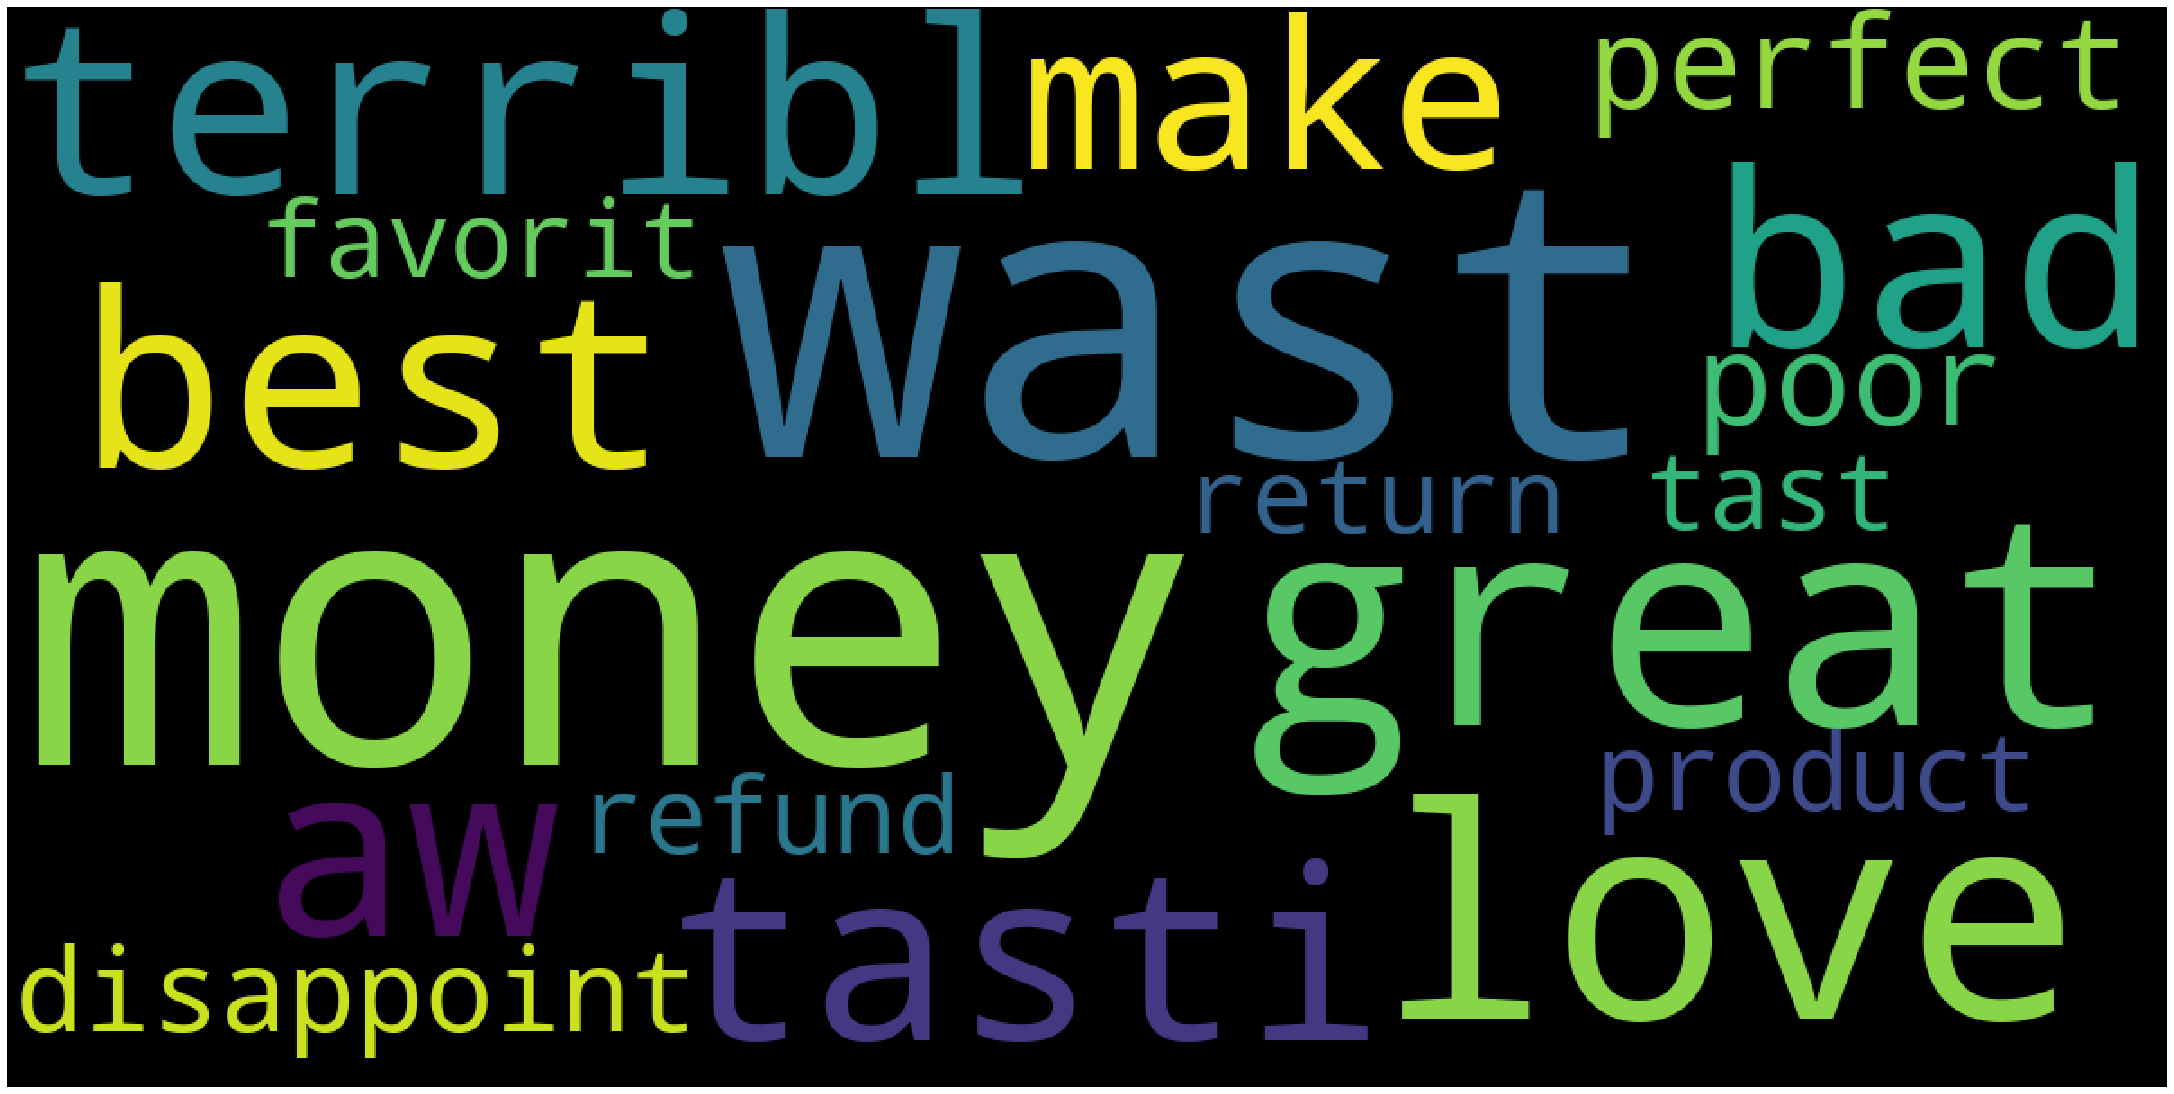

In [47]:
#Top 20 words of Random Forest model
top_features_rand(x_train_tfidf, y_train, tfidf_vect, optimal_estimators=600, optimal_depth=14)

### APPLYING DECISION TREE CLASSIFIER ON OUR MODEL

###### BAG OF WORDS

FOR samples = 5 and depth = 5
The accuracy of the model is: 86.00268521908947
The f1_score of the model is: 60.102043433316844
The precision_score of the model is: 78.57281943548222
The recall_score of the model is: 58.04431676292641
FOR samples = 5 and depth = 10
The accuracy of the model is: 86.41279140729891
The f1_score of the model is: 61.87669505472322
The precision_score of the model is: 80.34124770368247
The recall_score of the model is: 59.27755986686041
FOR samples = 5 and depth = 50
The accuracy of the model is: 87.0926400585866
The f1_score of the model is: 72.1325998101592
The precision_score of the model is: 76.10908300804667
The recall_score of the model is: 69.67318682340107
FOR samples = 5 and depth = 100
The accuracy of the model is: 86.79482485048212
The f1_score of the model is: 72.67090911819163
The precision_score of the model is: 75.08843048715784
The recall_score of the model is: 70.91204809819428
FOR samples = 10 and depth = 5
The accuracy of the model is: 86.0

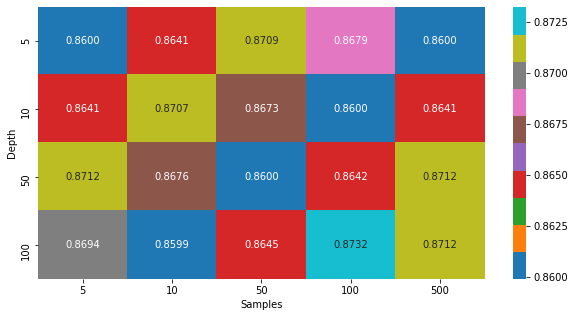

In [48]:
##Calling the Decision tree function to train our model using Bag of words
#This may take several minutes or even hours to run
decision_train(x_train_bow, x_cv_bow, y_train, y_cv)

The accuracy of the model is: 87.07721375764834
The macro f1_score of the model is: 71.98395174084699
The micro f1_score of the model is: 87.07721375764834
The precision_score of the model is: 76.44308706408384
The recall_score of the model is: 69.35578035255163
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.63      0.44      0.51     14310
    Positive       0.90      0.95      0.93     76723

    accuracy                           0.87     91033
   macro avg       0.76      0.69      0.72     91033
weighted avg       0.86      0.87      0.86     91033



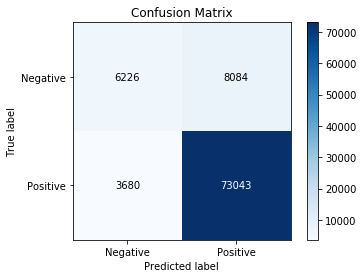

In [49]:
#Calling the Decision tree function to test the model
decision_test(x_train_bow, y_train, x_test_bow, y_test, optimal_samples=500, optimal_depth=50)

Feature Importance 	 Features
0.0934			disappoint
0.0520			wast money
0.0497			great
0.0484			return
0.0386			worst
0.0360			best
0.0348			love
0.0269			aw
0.0262			bad
0.0229			delici
0.0217			good
0.0199			terribl
0.0179			horribl
0.0159			threw
0.0152			perfect
0.0120			favorit
0.0111			excel
0.0104			nice
0.0099			thought
0.0096			descript


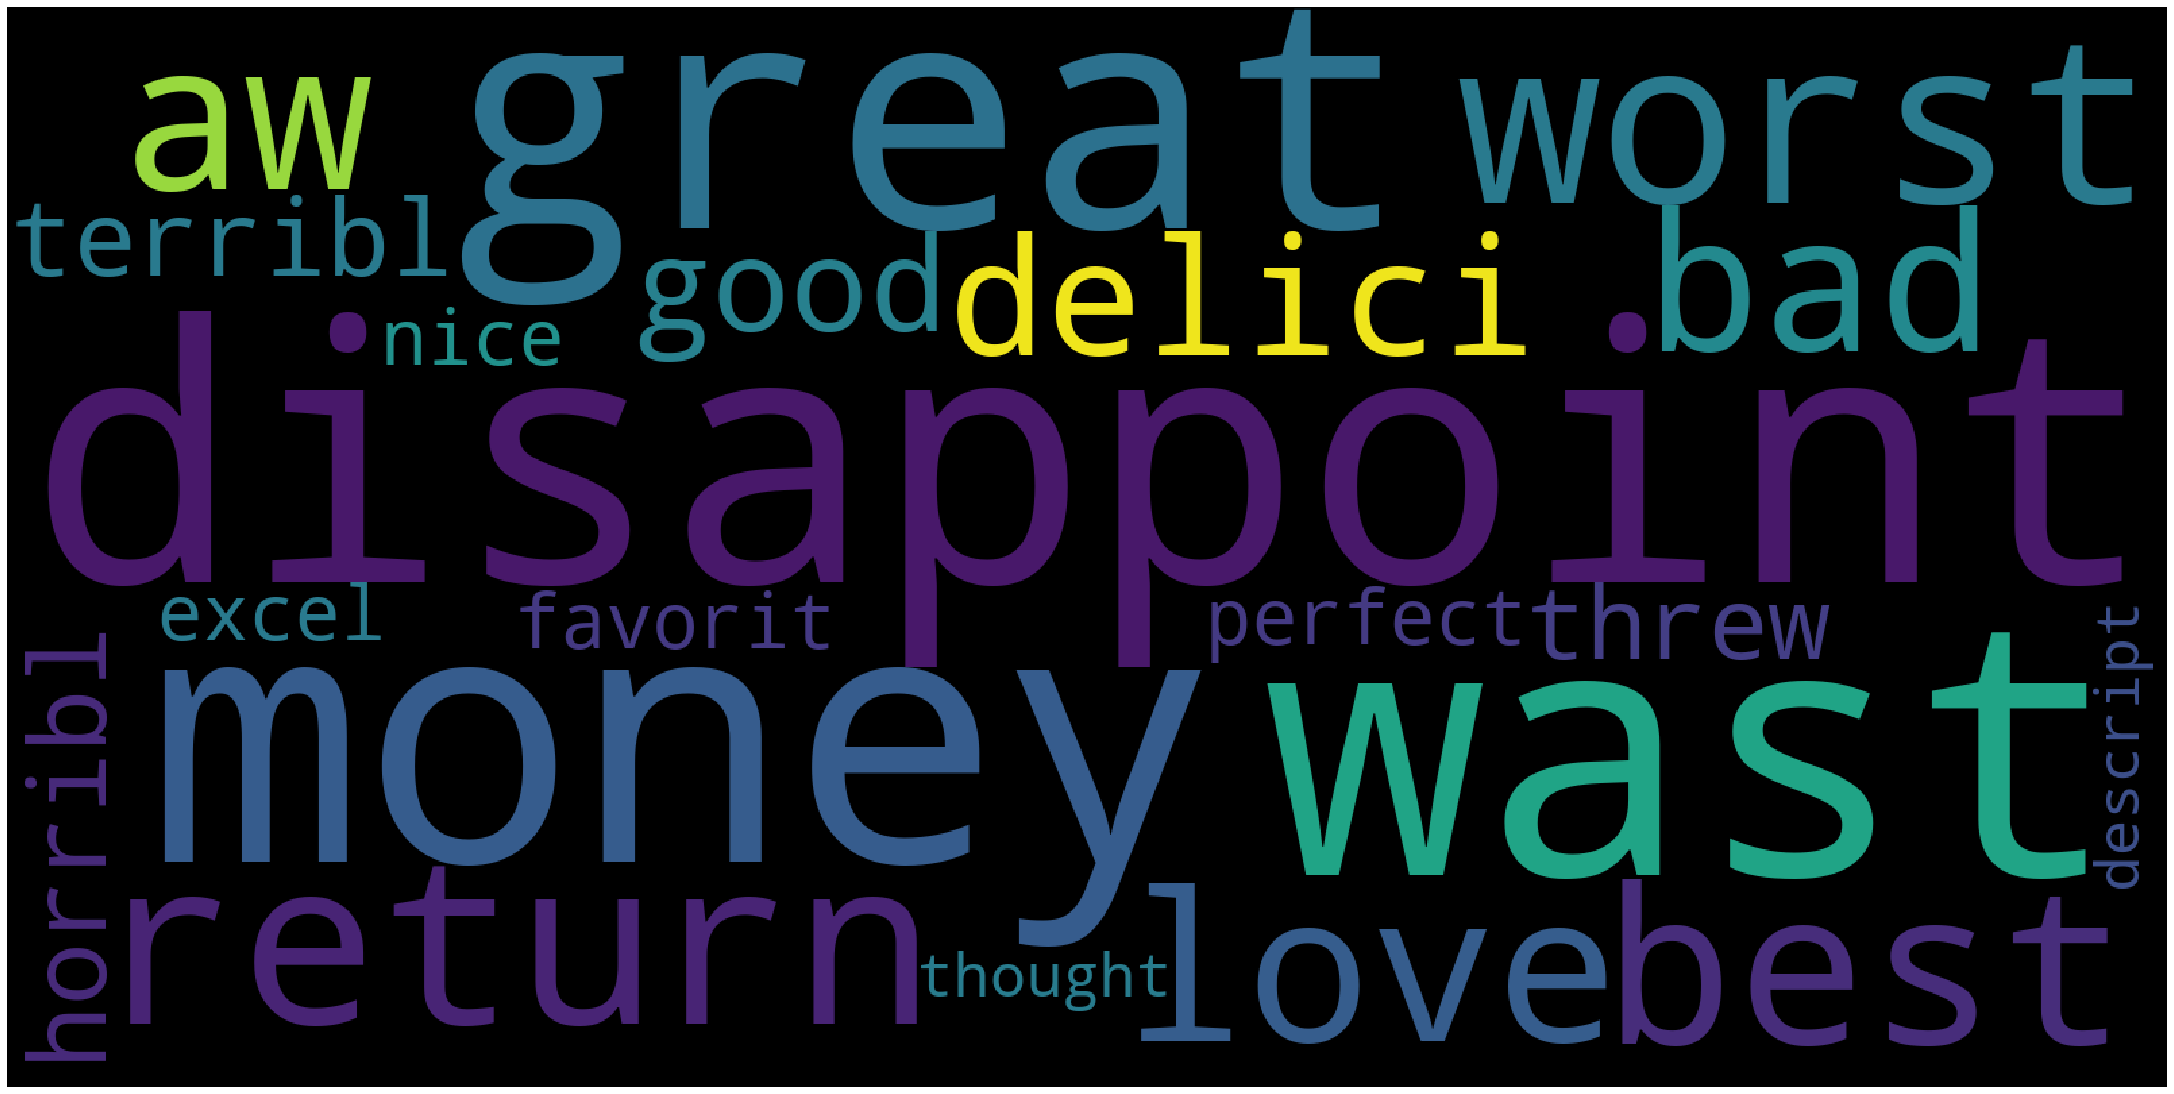

In [52]:
#Top 20 features of Decision tree using Bag of Words
top_features(x_train_bow, y_train, count_vect, optimal_samples=500, optimal_depth=50)

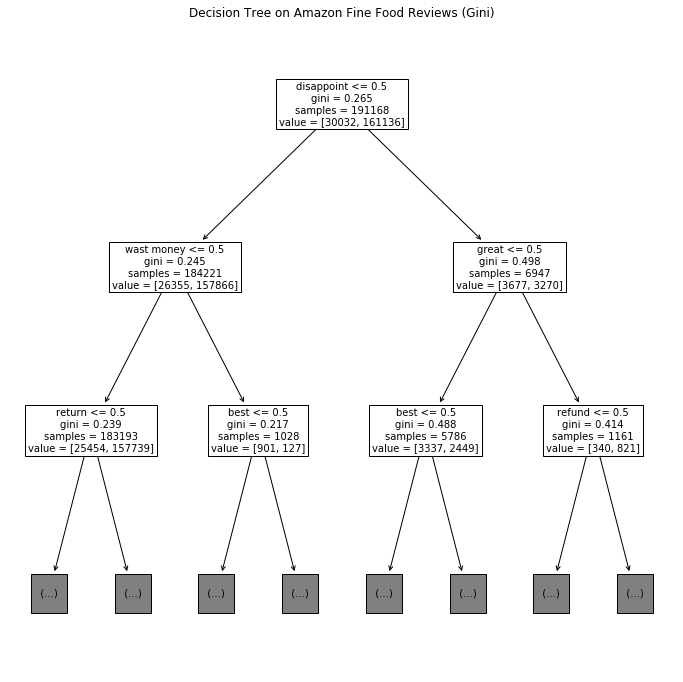

In [54]:
construct_tree(x_train_bow, y_train, count_vect, optimal_samples=500, optimal_depth=50)

###### TF-IDF

FOR samples = 5 and depth = 5
Accuracy: 86.12840229464177
F1 score: 61.13213248138136
Precision: 78.50574863951607
Recall: 58.776879583466844
FOR samples = 5 and depth = 10
Accuracy: 86.52264127914073
F1 score: 62.428307079236745
Precision: 80.63701029958233
Recall: 59.674867154461175
FOR samples = 5 and depth = 50
Accuracy: 86.5092151836934
F1 score: 70.85946222274137
Precision: 74.64005245176398
Recall: 68.54494821186844
FOR samples = 5 and depth = 100
Accuracy: 85.91236421335286
F1 score: 71.5602633372996
Precision: 73.0843579757386
Recall: 70.34786909454824
FOR samples = 10 and depth = 5
Accuracy: 86.12474063224704
F1 score: 61.13253200740881
Precision: 78.46980391655178
Recall: 58.777905605375004
FOR samples = 10 and depth = 10
Accuracy: 86.54461125350909
F1 score: 62.50181477923126
Precision: 80.75010101026525
Recall: 59.726215373812366
FOR samples = 10 and depth = 50
Accuracy: 86.36518979616746
F1 score: 70.71114084057726
Precision: 74.24800262249053
Recall: 68.50117833815968
FO

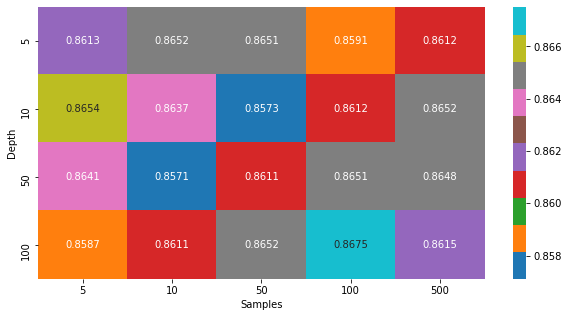

In [62]:
#Calling the Decision tree function to train our model using TF-IDF
#This may take several minutes or even hours to run
decision_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv)

Accuracy: 86.62353212571266
Macro f1 score: 71.25217570765653
Micro f1 score: 86.62353212571266
Precision: 75.20222280949272
Recall: 68.85639872508955
Classification Report:
               precision    recall  f1-score   support

    Negative       0.61      0.43      0.50     14310
    Positive       0.90      0.95      0.92     76723

    accuracy                           0.87     91033
   macro avg       0.75      0.69      0.71     91033
weighted avg       0.85      0.87      0.86     91033



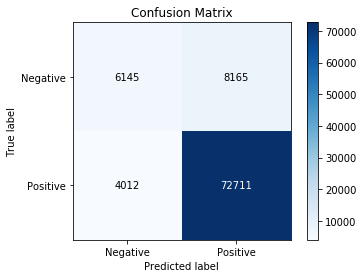

In [63]:
#Calling the Decision tree function to test the model
decision_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_samples=500, optimal_depth=50)

Feature Importance 	 Features
0.0895			disappoint
0.0508			wast money
0.0484			great
0.0484			return
0.0379			worst
0.0350			love
0.0342			best
0.0276			aw
0.0262			bad
0.0214			terribl
0.0206			delici
0.0196			good
0.0166			perfect
0.0161			horribl
0.0154			threw
0.0128			favorit
0.0113			excel
0.0101			refund
0.0099			descript
0.0094			disgust


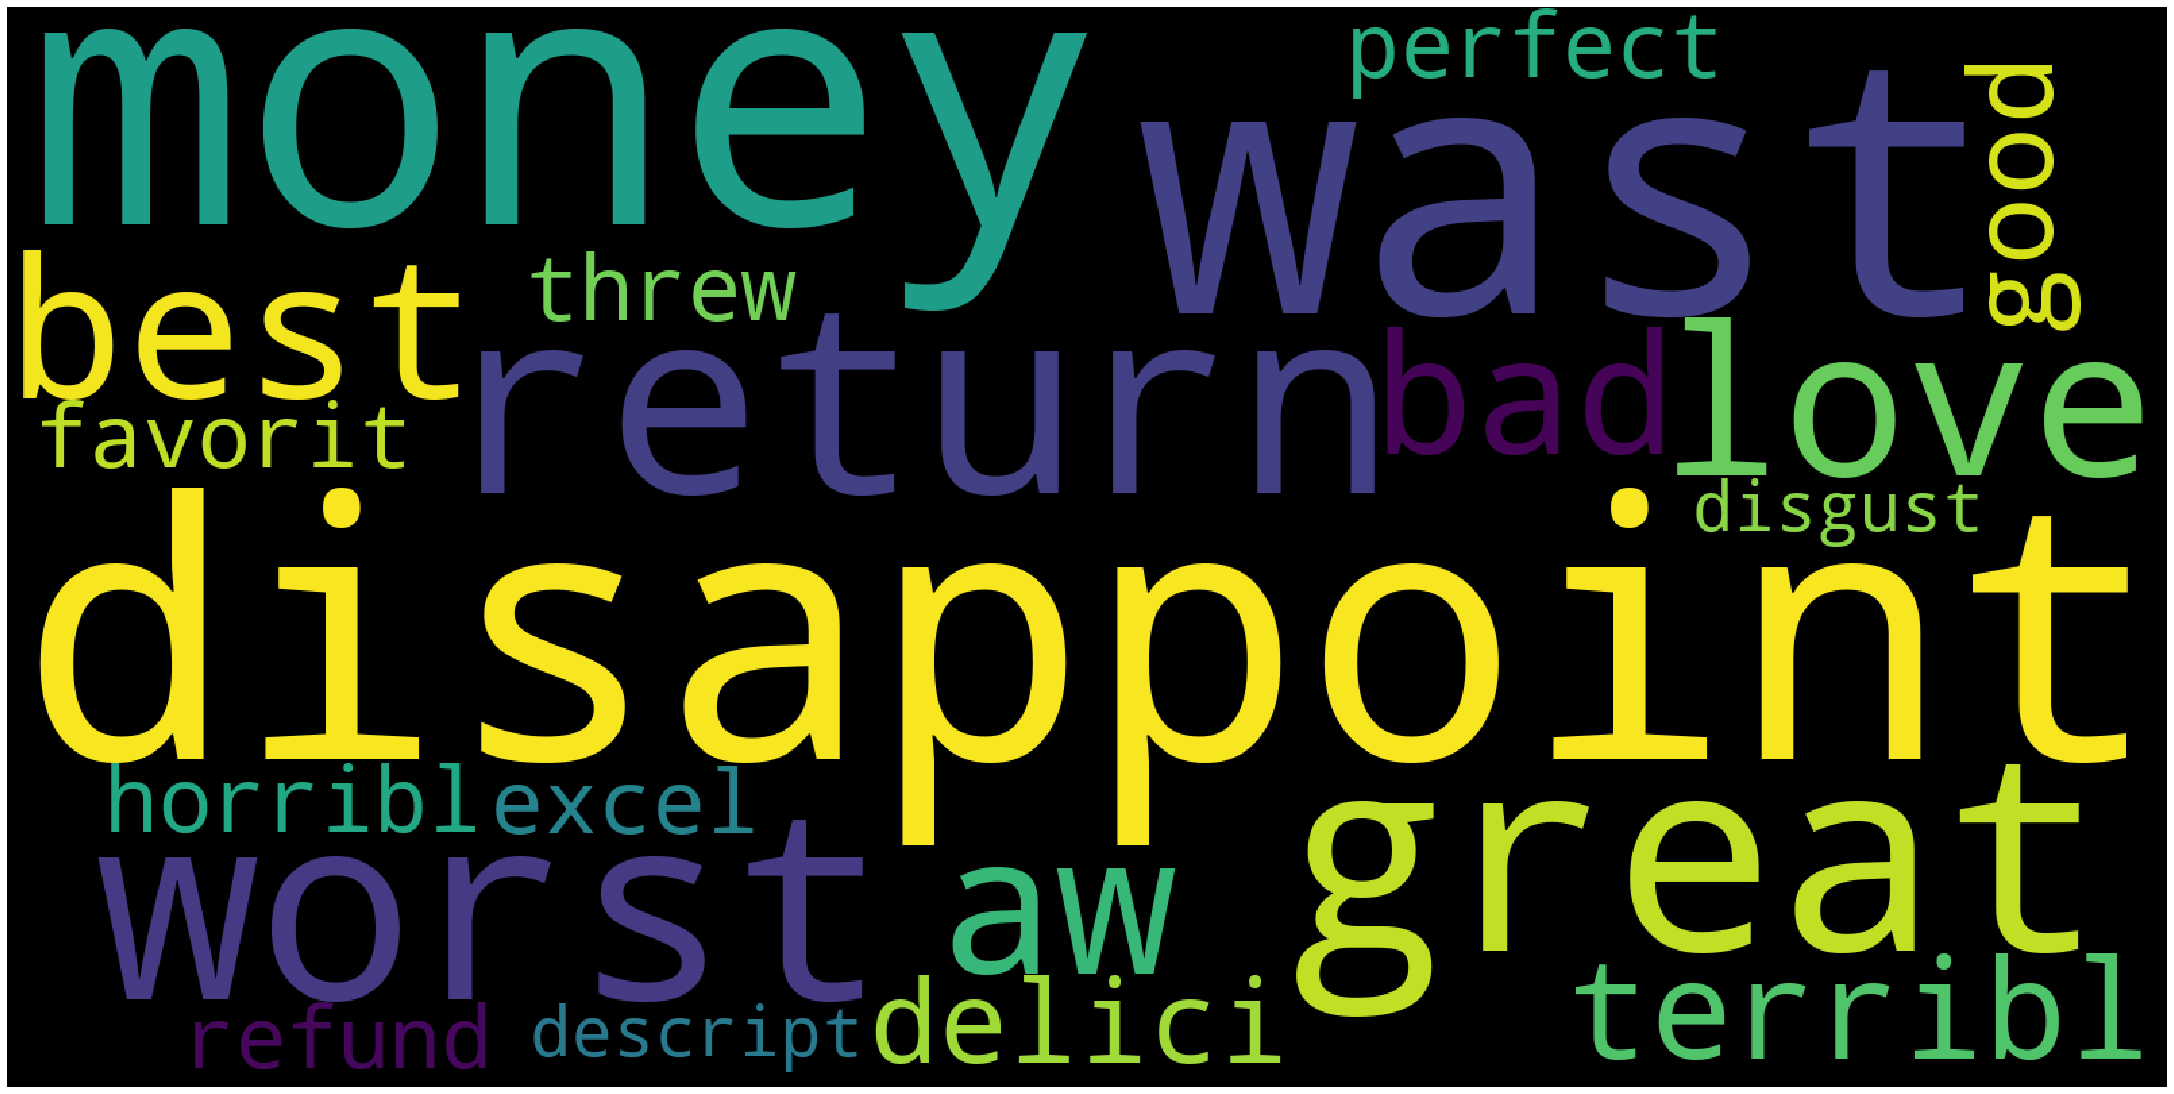

In [64]:
#Top 20 features of Decision tree using TF-IDF
top_features(x_train_tfidf, y_train, tfidf_vect, optimal_samples=500, optimal_depth=50)

### APPLYING SUPPORT VECTOR MACHINE ON OUR MODEL

###### BAG OF WORDS

FOR α = 1e-05
The accuracy of the model is: 90.25509581349934
The f1_score of the model is: 75.62011031477178
The precision_score of the model is: 92.01525232678989
The recall_score of the model is: 70.06758072200738
FOR α = 0.0001
The accuracy of the model is: 92.97449041865006
The f1_score of the model is: 85.38525481240211
The precision_score of the model is: 89.81910860028518
The recall_score of the model is: 82.19899130879806
FOR α = 0.001
The accuracy of the model is: 92.38984498962529
The f1_score of the model is: 84.08332582474284
The precision_score of the model is: 88.65891300526623
The recall_score of the model is: 80.86437425962733
FOR α = 0.01
The accuracy of the model is: 91.36702062736482
The f1_score of the model is: 81.33950019296759
The precision_score of the model is: 87.41707551682127
The recall_score of the model is: 77.55938892768044
FOR α = 0.1
The accuracy of the model is: 85.9257903088002
The f1_score of the model is: 56.41849741229088
The precision_score of th

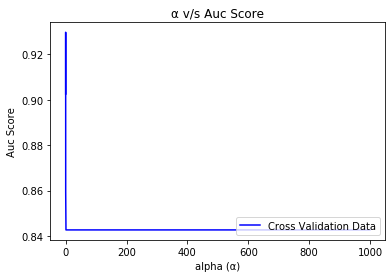

In [74]:
##Calling the SVM function to train our model using Bag of words
#This may take several minutes to run
svm_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='Linear')

The accuracy of the model is: 92.94651390155218
The macro f1_score of the model is: 85.21474670637228
The micro f1_score of the model is: 92.94651390155218
The precision_score of the model is: 89.49354410420078
The recall_score of the model is: 82.10972068125315
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.85      0.66      0.75     14146
    Positive       0.94      0.98      0.96     76887

    accuracy                           0.93     91033
   macro avg       0.89      0.82      0.85     91033
weighted avg       0.93      0.93      0.93     91033



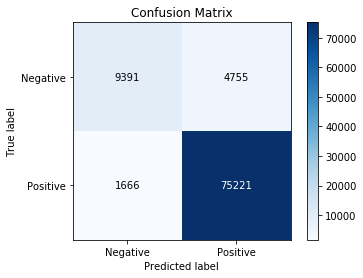

In [75]:
#Calling the SVM function to test the model
svm_test(x_train_bow, y_train, x_test_bow, y_test, optimal_alpha=0.0001, algo='Linear')

In [76]:
#Top 20 words of SVM using Bag of Words
top_features_svm(x_train_bow, y_train, count_vect, optimal_alpha=0.0001, algo='Linear')

These are the Top 10 Positive Features:
	 high recommend
	 never disappoint
	 delici
	 four star
	 awesom
	 perfect
	 worri
	 well worth
	 excel
	 fantast
These are the Top 10 Negative Features:
	 worst
	 two star
	 terribl
	 aw
	 disappoint
	 yuck
	 horribl
	 least favorit
	 want like
	 threw


###### TF-IDF

FOR α = 1e-05
The accuracy of the model is: 93.30770169657025
The f1_score of the model is: 86.62383348531519
The precision_score of the model is: 89.07658559605201
The recall_score of the model is: 84.60252329685996
FOR α = 0.0001
The accuracy of the model is: 92.06517759062615
The f1_score of the model is: 83.77919052301313
The precision_score of the model is: 87.11003483327708
The recall_score of the model is: 81.24607673140328
FOR α = 0.001
The accuracy of the model is: 91.93091663615282
The f1_score of the model is: 83.44444577680106
The precision_score of the model is: 86.92511987180593
The recall_score of the model is: 80.83191281743251
FOR α = 0.01
The accuracy of the model is: 91.94068106920543
The f1_score of the model is: 83.46210751483103
The precision_score of the model is: 86.95178601002573
The recall_score of the model is: 80.84401769358769
FOR α = 0.1
The accuracy of the model is: 84.27071890638351
The f1_score of the model is: 45.732018307909364
The precision_score of 

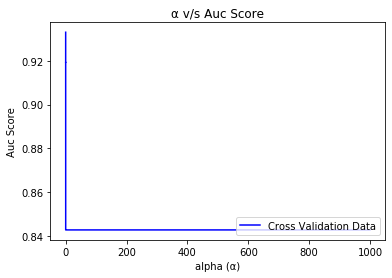

In [77]:
##Calling the SVM function to train our model using TF-IDF
#This may take several minutes to run
svm_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='Linear')

The accuracy of the model is: 93.32769435259742
The macro f1_score of the model is: 86.60081717545853
The micro f1_score of the model is: 93.32769435259742
The precision_score of the model is: 88.80234720189625
The recall_score of the model is: 84.75238897717425
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.83      0.72      0.77     14146
    Positive       0.95      0.97      0.96     76887

    accuracy                           0.93     91033
   macro avg       0.89      0.85      0.87     91033
weighted avg       0.93      0.93      0.93     91033



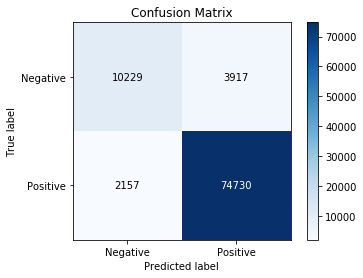

In [78]:
#Calling the SVM function to test the model
svm_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_alpha=0.00001, algo='Linear')

### APPLYING LOGISTIC REGRESSION ON OUR MODEL

##### BAG OF WORDS

FOR λ = 10000
The accuracy of the model is: 93.12461857683388
The f1_score of the model is: 86.32010683221442
The precision_score of the model is: 88.53740875522561
The recall_score of the model is: 84.46549410722852
FOR λ = 5000
The accuracy of the model is: 93.13926522641279
The f1_score of the model is: 86.35765969619591
The precision_score of the model is: 88.54826519100982
The recall_score of the model is: 84.52151973231537
FOR λ = 1000
The accuracy of the model is: 93.09166361528133
The f1_score of the model is: 86.27756020490317
The precision_score of the model is: 88.41394462169158
The recall_score of the model is: 84.48065369334306
FOR λ = 500
The accuracy of the model is: 92.9927987306237
The f1_score of the model is: 86.14125255830953
The precision_score of the model is: 88.07114920156779
The recall_score of the model is: 84.49457552597491
FOR λ = 100
The accuracy of the model is: 93.09410472354449
The f1_score of the model is: 86.29364679874
The precision_score of the model

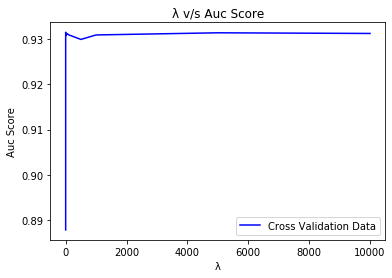

In [87]:
##Calling the Logistic Regression function to train our model using Bag of Words
#This may take several minutes to run
logistic_train(x_train_bow, x_cv_bow, y_train, y_cv, penal='l2')

The accuracy of the model is: 93.13875188118594
The macro f1_score of the model is: 86.25145598760884
The micro f1_score of the model is: 93.13875188118594
The precision_score of the model is: 88.33090058997311
The recall_score of the model is: 84.49343910115137
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.82      0.72      0.77     14146
    Positive       0.95      0.97      0.96     76887

    accuracy                           0.93     91033
   macro avg       0.88      0.84      0.86     91033
weighted avg       0.93      0.93      0.93     91033



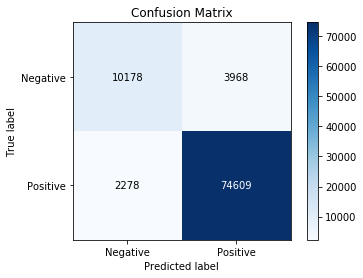

In [88]:
#Calling the Logistic Regression function to test the model
logistic_test(x_train_bow, y_train, x_test_bow, y_test, penal='l2', optimal_C=1000)

###### TF-IDF

FOR λ = 10000
The accuracy of the model is: 93.31868668375442
The f1_score of the model is: 86.64256455410478
The precision_score of the model is: 89.10824642939367
The recall_score of the model is: 84.61219666682057
FOR λ = 5000
The accuracy of the model is: 93.3150250213597
The f1_score of the model is: 86.64215633738976
The precision_score of the model is: 89.08276087041762
The recall_score of the model is: 84.62895826311778
FOR λ = 1000
The accuracy of the model is: 93.33333333333333
The f1_score of the model is: 86.64603236550008
The precision_score of the model is: 89.20619512627017
The recall_score of the model is: 84.55146166677407
FOR λ = 500
The accuracy of the model is: 93.35896497009642
The f1_score of the model is: 86.67569657085896
The precision_score of the model is: 89.31794291589968
The recall_score of the model is: 84.52564557725758
FOR λ = 100
The accuracy of the model is: 93.38459660685952
The f1_score of the model is: 86.66926000233437
The precision_score of the mo

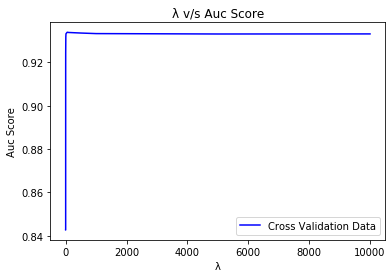

In [89]:
##Calling the Logistic Regression function to train our model using TF-IDF
#This may take several minutes to run
logistic_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, penal='l2')

The accuracy of the model is: 93.38481649511715
The macro f1_score of the model is: 86.39028040019001
The micro f1_score of the model is: 93.38481649511715
The precision_score of the model is: 89.78015548554018
The recall_score of the model is: 83.76517570552267
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.85      0.70      0.77     14146
    Positive       0.95      0.98      0.96     76887

    accuracy                           0.93     91033
   macro avg       0.90      0.84      0.86     91033
weighted avg       0.93      0.93      0.93     91033



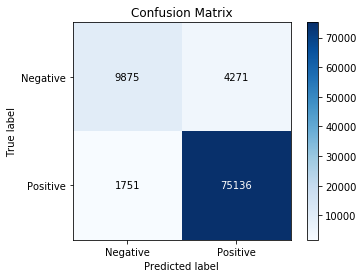

In [90]:
#Calling the Logistic Regression function to test the model
logistic_test(x_train_tfidf, y_train, x_test_tfidf, y_test, penal='l2', optimal_C=10)

FOR K = 2
The accuracy of the model is: 56.13938728182595
The f1_score of the model is: 49.22232378763173
The precision_score of the model is: 54.34361379174143
The recall_score of the model is: 58.16949846767232
FOR K = 4
The accuracy of the model is: 83.4859025997803
The f1_score of the model is: 55.553209947111945
The precision_score of the model is: 63.902451011779235
The recall_score of the model is: 54.9779178451123
FOR K = 6
The accuracy of the model is: 84.31954107164653
The f1_score of the model is: 52.853058939982375
The precision_score of the model is: 68.07478556610192
The recall_score of the model is: 53.42133696907301
FOR K = 8
The accuracy of the model is: 84.47455144635666
The f1_score of the model is: 51.05520767107471
The precision_score of the model is: 70.581443173004
The recall_score of the model is: 52.503487016127245
FOR K = 10
The accuracy of the model is: 84.5123886244355
The f1_score of the model is: 50.109036716939606
The precision_score of the model is: 72.3

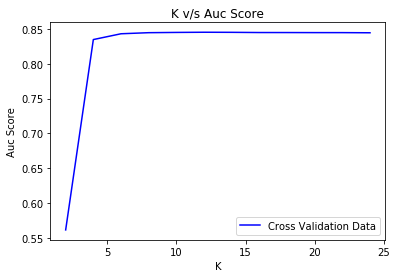

In [94]:
##Calling the KNN function to train our model using Bag of Words
#This may take several minutes or even hours to run
knn_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='brute')

The accuracy of the model is: 84.65831072248525
The macro f1_score of the model is: 48.33071789081903
The micro f1_score of the model is: 84.65831072248525
The precision_score of the model is: 75.47943541118562
The recall_score of the model is: 51.17846371319561
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.66      0.03      0.05     14146
    Positive       0.85      1.00      0.92     76887

    accuracy                           0.85     91033
   macro avg       0.75      0.51      0.48     91033
weighted avg       0.82      0.85      0.78     91033



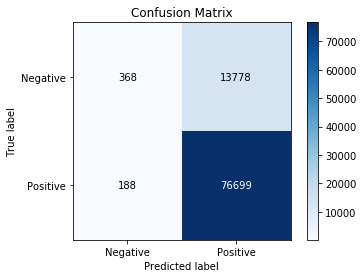

In [95]:
#Calling the KNN function to test the model
knn_test(x_train_bow, y_train, x_test_bow, y_test, algo='brute', optimal_k=18)

FOR K = 2
The accuracy of the model is: 81.92969608202124
The f1_score of the model is: 63.90207224876021
The precision_score of the model is: 64.85286017434954
The recall_score of the model is: 63.168220360481484
FOR K = 4
The accuracy of the model is: 85.1617234224338
The f1_score of the model is: 64.34995741756269
The precision_score of the model is: 71.67200920406961
The recall_score of the model is: 61.848125307712486
FOR K = 6
The accuracy of the model is: 86.0820212376419
The f1_score of the model is: 63.795552138607135
The precision_score of the model is: 76.46438762081071
The recall_score of the model is: 60.929920482650004
FOR K = 8
The accuracy of the model is: 86.30050042719395
The f1_score of the model is: 62.66883962987717
The precision_score of the model is: 79.29350611649924
The recall_score of the model is: 59.91403344072739
FOR K = 10
The accuracy of the model is: 86.36274868790431
The f1_score of the model is: 61.776184654005995
The precision_score of the model is: 8

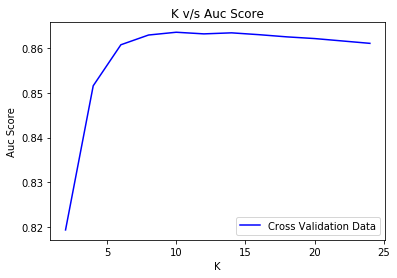

In [96]:
##Calling the KNN function to train our model using TF-IDF
#This may take several minutes or even hours to run
knn_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='brute')

The accuracy of the model is: 86.47523425570947
The macro f1_score of the model is: 60.86209537201116
The micro f1_score of the model is: 86.47523425570947
The precision_score of the model is: 82.5230483417679
The recall_score of the model is: 58.515803324313886
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.78      0.18      0.29     14146
    Positive       0.87      0.99      0.93     76887

    accuracy                           0.86     91033
   macro avg       0.83      0.59      0.61     91033
weighted avg       0.85      0.86      0.83     91033



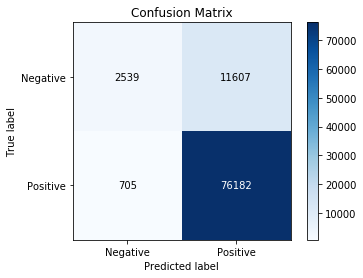

In [97]:
#Calling the KNN function to test the model
knn_test(x_train_tfidf, y_train, x_test_tfidf, y_test, algo='brute', optimal_k=12)